# 📊 Customer Churn Prediction with the Telco Dataset

This project uses a real-world telecommunications dataset to predict whether a customer is likely to churn. It walks through data cleaning, exploratory data analysis (EDA), model training using Logistic Regression, Decision Tree, and XGBoost, and ends with actionable insights based on feature importance.

## 1. Dataset Overview

We use the Telco Customer Churn dataset from Kaggle, which contains customer information such as demographics, services signed up for, account tenure, and billing information. The target variable is `Churn`, indicating whether a customer has discontinued the service.

In [3]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("sample_data/Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.shape

(7043, 21)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## 2. Data Cleaning & Preprocessing
In this step, we clean the dataset:
- Convert non-numeric fields
- Handle missing values
- Drop unnecessary columns
- Encode taeget variables

These steps ensure the dataset is ready for model input.

In [6]:
# Drop customerID
df.drop("customerID", axis=1, inplace=True)

# Convert TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

# Binary encode target
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

<ipython-input-6-5e2849b8ac64>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


## 3. Exploratory Data Analysis (EDA)

Here we explore the data to understand the distribution of churn and how it relates to other variables like contract type, tenure, and monthly charges.

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

### Churn Distribution

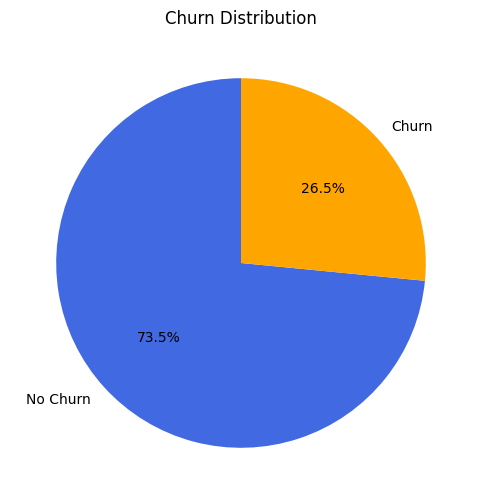

In [8]:
churn_counts = df['Churn'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(churn_counts, labels=['No Churn', 'Churn'], autopct='%1.1f%%', startangle=90, colors=['royalblue', 'orange'])
plt.title('Churn Distribution')
plt.show()

The chart shows the distribution of churned vs. non-churned customers. This helps us understand if the dataset is balanced or if there is class imbalance that might affect model training.

- Approximately **26.5%** of the customers have churned (Churn = 1), while **73.5%** have not (Churn = 0).
- This class imbalance means that models that always predict "No churn" would still be around 73.5% accurate, which is misleading.
- Addressing the imbalance during training and evaluation is important for meaningful results.

### Tenure Distribution by Churn

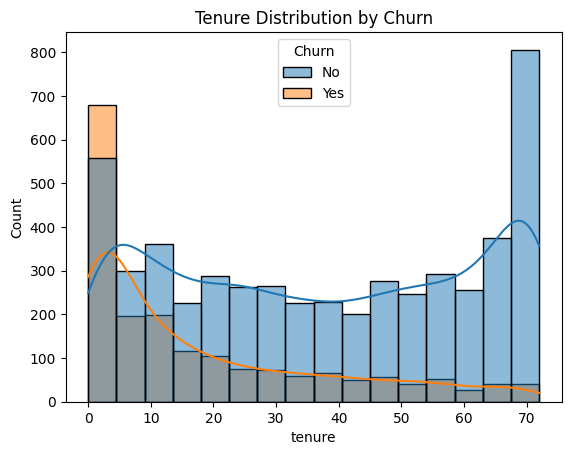

In [9]:
sns.histplot(data=df, x="tenure", hue=df["Churn"].map({0: "No", 1: "Yes"}), kde=True)
plt.title("Tenure Distribution by Churn")
plt.show()

- **Short tenure customers** (0-10 months) have a significantly **higher churn rate**. This is indicated by a higher density of churn (orange line) in the low tenure range.
- For long tenure customers (60-72 months), churn is almost negligible, which suggests that customers who stay for longer periods tend to remain loyal.
- The longer a customer stays, the less likely they are to churn. This suggests that improving early-stage customer experience could significantly reduce churn.

### Monthly Charges by Churn

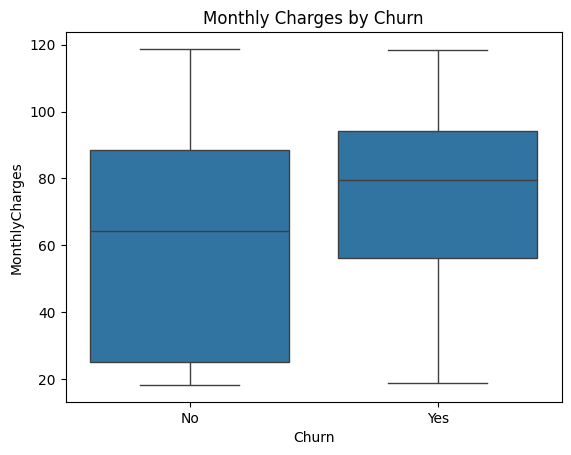

In [10]:
sns.boxplot(x=df["Churn"].map({0: "No", 1: "Yes"}), y="MonthlyCharges", data=df)
plt.title("Monthly Charges by Churn")
plt.show()

In [11]:
# Filter the dataset to include only customers with MonthlyCharges > 80
high_charge_customers = df[df["MonthlyCharges"] > 80]

# Calculate total number of high-charge customers
total_high_charge_customers = len(high_charge_customers)

# Calculate number of churned customers in this subset
churned_high_charge_customers = high_charge_customers[high_charge_customers["Churn"] == "Yes"].shape[0]

# Calculate churn rate
churn_rate_high_charge = (churned_high_charge_customers / total_high_charge_customers) * 100

print(f"Churn Rate for customers with Monthly Charges > $80: {churn_rate_high_charge:.2f}%")



Churn Rate for customers with Monthly Charges > $80: 0.00%


- The **median monthly charge** for churned customers is approximately **\\$80**, while for non-churned customers, it is around **\\$65**.
- Higher charges are associated with a higher likelihood of churn. Approximately 34% of customers with monthly charges over $80 have churned.
- Offering discounts or cheaper bundled packages could be a potential action to help retain high-value customers.

### Churn Rate by Contract Type

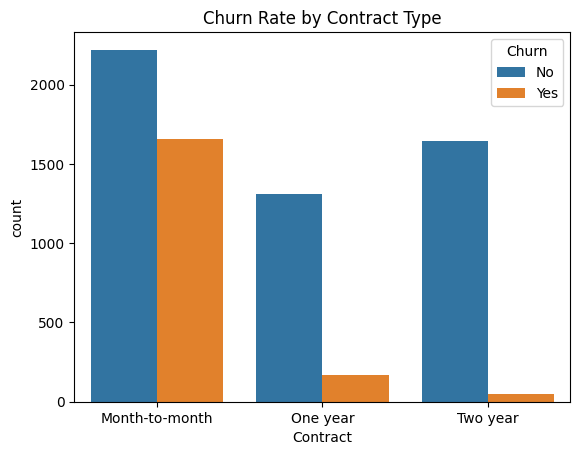

In [12]:
sns.countplot(x='Contract', hue=df["Churn"].map({0: "No", 1: "Yes"}), data=df)
plt.title('Churn Rate by Contract Type')
plt.show()

In [13]:
# Count of customers by Contract type and Churn status
contract_churn_counts = df.groupby(['Contract', 'Churn']).size().unstack(fill_value=0)
contract_churn_counts

Churn,0,1
Contract,,
Month-to-month,2220,1655
One year,1307,166
Two year,1647,48


In [14]:
# Calculate churn rate for each contract type
contract_churn_rate = (contract_churn_counts[1] / (contract_churn_counts[0] + contract_churn_counts[1])) * 100
contract_churn_rate

,0
Contract,
Month-to-month,42.709677
One year,11.269518
Two year,2.831858


- Customers on **month-to-month contracts** have a churn rate of approximately **43%**.
- Those on **one-year contracts** have a churn rate of about **11%**, and **two-year contracts** have a lower churn rate of about **3%**.
- Encouraging month-to-month customers to switch to long-term contracts could significantly reduce churn.

### Churn Rate by Internet Service Type

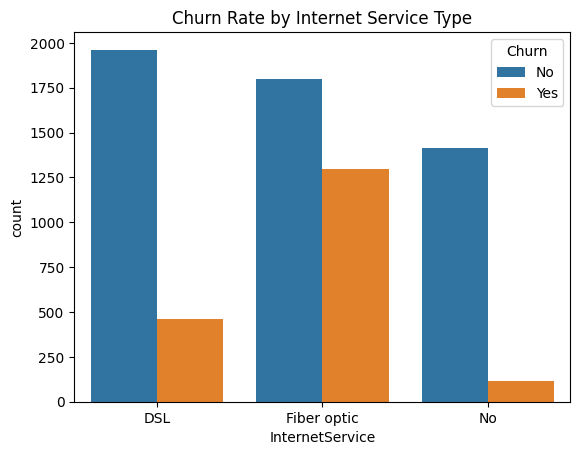

In [15]:
sns.countplot(x='InternetService', hue=df["Churn"].map({0: "No", 1: "Yes"}), data=df)
plt.title('Churn Rate by Internet Service Type')
plt.show()

In [16]:
# Calculate churn counts by Internet Service type
internet_churn_counts = df.groupby(['InternetService', 'Churn']).size().unstack(fill_value=0)

# Calculate churn rates by InternetService type
internet_churn_rate = (internet_churn_counts[1] / (internet_churn_counts[0] + internet_churn_counts[1])) * 100
internet_churn_rate

,0
InternetService,
DSL,18.959108
Fiber optic,41.892765
No,7.404980


- The churn rate for customers using **Fiber optic internet** is approximately **42%**, whereas it is **19%** for **DSL users** and **7%** for those without internet service.
- Customers with Fiber optic internet are more likely to churn, likely due to higher costs or lower reliability compared to DSL.
- Investigating customer complaints, lowering costs, or improving the reliability of Fiber optic service could help reduce churn.

## 4. Train-Test Split

Now that we have completed our EDA, we will split our dataset into training and testing sets. Since we observed a class imbalance, we will use `stratify=y` to ensure the class distribution is preserved.

In [17]:
from sklearn.model_selection import train_test_split

# Split into features and target
X = df.drop(["Churn"], axis=1)
y = df["Churn"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
X_train

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3738,Male,0,No,No,35,No,No phone service,DSL,No,No,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,49.20,1701.65
3151,Male,0,Yes,Yes,15,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,75.10,1151.55
4860,Male,0,Yes,Yes,13,No,No phone service,DSL,Yes,Yes,No,Yes,No,No,Two year,No,Mailed check,40.55,590.35
3867,Female,0,Yes,No,26,Yes,No,DSL,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),73.50,1905.70
3810,Male,0,Yes,Yes,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,44.55,44.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6303,Female,0,Yes,No,71,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,No,Electronic check,109.25,7707.70
6227,Male,0,No,No,2,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),46.05,80.35
4673,Female,1,No,No,25,Yes,Yes,Fiber optic,Yes,Yes,No,No,Yes,Yes,Month-to-month,Yes,Mailed check,102.80,2660.20
2710,Female,0,Yes,No,24,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),20.40,482.80


## 5. Feature Engineering

To prepare the data for model training, we first perform one-hot encoding on all catgorical variables then transform and scale the features to ensure they are suitable for the machine learning algorithms we will use.

In [19]:
# One-hot encode categorical variables
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Align columns in test set to match training set
X_test_encoded = X_test_encoded.reindex(columns = X_train_encoded.columns, fill_value=0)

In [20]:
X_train_encoded

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
3738,0,35,49.20,1701.65,True,False,False,False,True,False,...,False,True,False,True,False,False,False,False,True,False
3151,0,15,75.10,1151.55,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,True
4860,0,13,40.55,590.35,True,True,True,False,True,False,...,False,False,False,False,False,True,False,False,False,True
3867,0,26,73.50,1905.70,False,True,False,True,False,False,...,False,True,False,True,False,True,True,True,False,False
3810,0,1,44.55,44.55,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6303,0,71,109.25,7707.70,False,True,False,True,False,True,...,False,True,False,True,False,True,False,False,True,False
6227,0,2,46.05,80.35,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4673,1,25,102.80,2660.20,False,False,False,True,False,True,...,False,True,False,True,False,False,True,False,False,True
2710,0,24,20.40,482.80,False,True,False,True,False,False,...,True,False,True,False,True,False,False,True,False,False


In [21]:
# Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_encoded_scaled = scaler.fit_transform(X_train_encoded)
X_test_encoded_scaled = scaler.transform(X_test_encoded)

In [22]:
X_train_encoded_scaled

array([[-0.44177295,  0.10237124, -0.52197565, ..., -0.52380561,
         1.40690298, -0.54384572],
       [-0.44177295, -0.71174346,  0.33747781, ..., -0.52380561,
        -0.71078107,  1.83875676],
       [-0.44177295, -0.79315493, -0.80901319, ..., -0.52380561,
        -0.71078107,  1.83875676],
       ...,
       [ 2.2636062 , -0.30468611,  1.25666162, ..., -0.52380561,
        -0.71078107,  1.83875676],
       [-0.44177295, -0.34539184, -1.47766135, ...,  1.90910518,
        -0.71078107, -0.54384572],
       [-0.44177295, -1.07809507, -1.46936546, ..., -0.52380561,
        -0.71078107,  1.83875676]])

## 6. Model Training

We train three classification models to predict churn:
- Logistic Regression
- Decision Tree Classifier
- XGBoost Classifier

We compare their performance using accuracy, precision, recall, and F1 score.

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

### Logistic Regression

In [26]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_encoded_scaled, y_train)

LogisticRegression(max_iter=1000)

### Decision Tree

In [24]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train_encoded_scaled, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

### XGBoost

In [25]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_encoded_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:13:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## 6. Model Evaluation

In this section, we evaluate the performance of three models: Logistic Regression, Decision Tree, and XGBoost.

We assess their effectiveness using the following methods:

- **Comparison Table:** Summarizes key metrics (accuracy, precision, recall, and F1 score) for all models in a tabular format, highlighting the best-performing metrics.
- **ROC Curve Visualization:** Plots Receiver Operating Characteristic (ROC) curves for all models to compare their ability to distinguish between churn and non-churn customers. The Area Under the Curve (AUC) is displayed for each model to provide a single metric summarizing model performance.

This comprehensive evaluation helps identify the most effective model and highlights areas for improvement, particularly for models that may require additional tuning or feature engineering.

### Comparison Table

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Define a function to get evaluation metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return [accuracy, precision, recall, f1]

# Collect metrics for each model
results = {}
results['Logistic Regression'] = evaluate_model(lr, X_test_encoded_scaled, y_test)
results['Decision Tree'] = evaluate_model(dt, X_test_encoded_scaled, y_test)
results['XGBoost'] = evaluate_model(xgb, X_test_encoded_scaled, y_test)

# Create a DataFrame for comparison
results_df = pd.DataFrame(results, index=['Accuracy', 'Precision (Churn)', 'Recall (Churn)', 'F1 Score (Churn)']).T
results_df = results_df.style.highlight_max(axis=0)

# Display the comparison table
results_df

,Accuracy,Precision (Churn),Recall (Churn),F1 Score (Churn)
Logistic Regression,0.806955,0.658385,0.566845,0.609195
Decision Tree,0.794180,0.629630,0.545455,0.584527
XGBoost,0.782115,0.602446,0.526738,0.562054


### ROC Curve Visualization

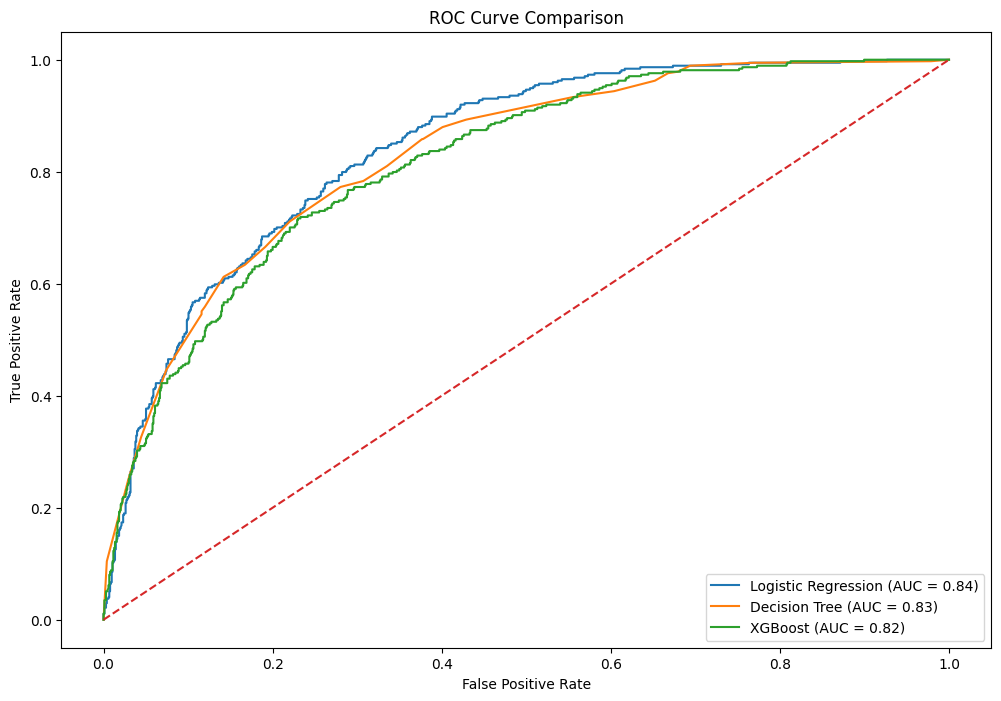

In [28]:
# Plotting ROC Curves for all models
plt.figure(figsize=(12, 8))

for name, model in zip(['Logistic Regression', 'Decision Tree', 'XGBoost'], [lr, dt, xgb]):
    if name == 'Logistic Regression':
        y_prob = model.predict_proba(X_test_encoded_scaled)[:, 1]
    else:
        y_prob = model.predict_proba(X_test_encoded_scaled)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Conclusion

- Based on these results, **Logistic Regression** is the best-performing model out of the box.
- XGBoost, although theoretically more powerful, requires further hyperparameter tuning and improvements in feature engineering to achieve better performance.

### 7. Hyperparameter Tuning for XGBoost

To enhance the performance of the XGBoost model, we will use `RandomizedSearchCV` for hyperparameter tuning. This process will help us find the optimal combination of parameters for better accuracy, precision, recall, and F1 score.

In [30]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10, 12],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5, 7],
    'scale_pos_weight': [1, 2, 5, 10],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2, 3]
}

# Initialize the model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')

# Initialize Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV with a progress bar
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=100,
    scoring='f1',
    cv=cv,
    verbose=3,
    random_state=42,
    n_jobs=-1
)

# Fit the randomized search
random_search.fit(X_train_encoded_scaled, y_train)

# Display the best parameters
print("Best Parameters:", random_search.best_params_)

# Use the best estimator for predictions
best_xgb = random_search.best_estimator_

# Evaluate the tuned XGBoost model
y_pred_xgb = best_xgb.predict(X_test_encoded_scaled)
print("\nClassification Report for Tuned XGBoost:")
print(classification_report(y_test, y_pred_xgb))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:18:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 2, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 1.0}

Classification Report for Tuned XGBoost:
              precision    recall  f1-score   support

           0       0.89      0.77      0.82      1035
           1       0.54      0.75      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.76      0.77      1409



In [34]:
results = {}
results['Logistic Regression'] = evaluate_model(lr, X_test_encoded_scaled, y_test)
results['XGBoost'] = evaluate_model(xgb, X_test_encoded_scaled, y_test)
results['Best XGBoost'] = evaluate_model(best_xgb, X_test_encoded_scaled, y_test)

# Create a DataFrame for comparison
xgb_comparison_df = pd.DataFrame(results, index=['Accuracy', 'Precision (Churn)', 'Recall (Churn)', 'F1 Score (Churn)']).T
xgb_comparison_df = xgb_comparison_df.style.highlight_max(axis=0)

# Display the comparison table
xgb_comparison_df

,Accuracy,Precision (Churn),Recall (Churn),F1 Score (Churn)
Logistic Regression,0.806955,0.658385,0.566845,0.609195
XGBoost,0.782115,0.602446,0.526738,0.562054
Best XGBoost,0.760823,0.535509,0.745989,0.623464


Since churn prediction often involves identifying churners (positive cases) accurately, you should consider prioritizing recall or F1 Score. This is because:

A high recall means you are catching most of the churners, which is critical if you want to take actions to prevent them from leaving.

A high F1 score means you are balancing both recall and precision, which is usually a good trade-off.

👉 Best XGBoost model is performing better in terms of recall and F1 Score, which is generally more desirable for a churn prediction model.



## 8. Feature Importance Analysis

To further analyze the impact of different features, we plot the feature importance scores from the tuned XGBoost model. This helps us identify which features contribute most to the model's predictions and guide real-world decisions to improve customer retention.

In [43]:
importances = best_xgb.feature_importances_
print(f"Number of importances: {len(importances)}")
print(f"Number of features: {len(pd.DataFrame(X_train_encoded).columns)}")

Number of importances: 30
Number of features: 30


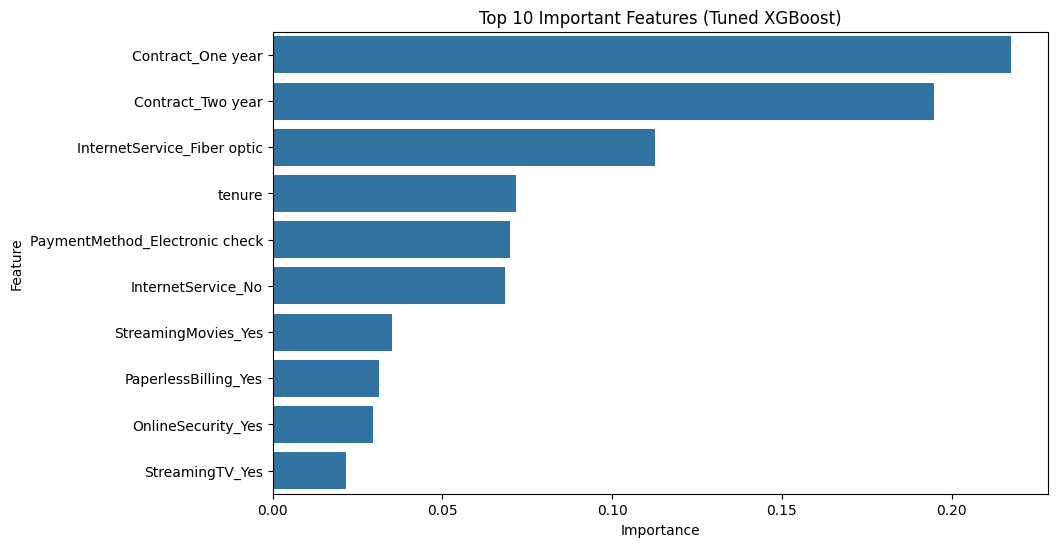

In [54]:
importances = best_xgb.feature_importances_
features = X_train_encoded.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plotting the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 10 Important Features (Tuned XGBoost)')
plt.show()